## Ultimate goal:

1. Use spikeinterfaces tools to load data (in neuralynx) and run spike sorting
2. After conversion to nwb - run spike sorting on that data

## Status update:

so far not that much progress -- besides complaining to spikeinterfaces ppl.

In [1]:
# Recommended import aliases: https://spikeinterface.readthedocs.io/en/latest/getting_started/plot_getting_started.html
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
# Additional imports
import os.path as op
import neo  # neo for some direct reading to check on # of segments etc

In [5]:
for m in se, st, ss, sc, sw, neo:
    print(str(m.__name__), getattr(m, '__version__'))

spikeinterface.extractors 0.8.4
spikeinterface.toolkit 0.6.3
spikeinterface.sorters 0.3.3
spikeinterface.comparison 0.2.3
spikeinterface.widgets 0.4.1
neo 0.8.0


In [6]:
se.installed_recording_extractor_list

[spikeextractors.extractors.mdaextractors.mdaextractors.MdaRecordingExtractor,
 spikeextractors.extractors.biocamrecordingextractor.biocamrecordingextractor.BiocamRecordingExtractor,
 spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaRecordingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortRecordingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusRecordingExtractor,
 spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor.SpikeGLXRecordingExtractor,
 spikeextractors.extractors.phyextractors.phyextractors.PhyRecordingExtractor,
 spikeextractors.extractors.maxonerecordingextractor.maxonerecordingextractor.MaxOneRecordingExtractor,
 spikeextractors.extractors.mea1krecordingextractor.mea1krecordingextractor.Mea1kRecordingExtractor,
 spikeextractors.extractors.

In [7]:
# To get klusta (klustakwik?) -- followed docs and ran `pip install click klusta klustakwik2` 
ss.installed_sorter_list

[spikesorters.klusta.klusta.KlustaSorter]

In [8]:
ss.get_default_params('klusta')

{'adjacency_radius': None,
 'threshold_strong_std_factor': 5,
 'threshold_weak_std_factor': 2,
 'detect_sign': -1,
 'extract_s_before': 16,
 'extract_s_after': 32,
 'n_features_per_channel': 3,
 'pca_n_waveforms_max': 10000,
 'num_starting_clusters': 50}

# Sample Neuralynx recording analysis attempt 

## Read the data
Use `neo` directly to get sense of the data and then specific extractor

In [82]:
# get a sample file, available via DataLad or you could download manually by 
# visiting http://datasets.datalad.org/?dir=/labs/mvdm/MotivationalT-v2/R050/R050-2014-03-31_raw
#import datalad.api as dl
#ds = dl.install("///labs/mvdm/MotivationalT-v2")
#sample_file = ds.get('R050/R050-2014-03-31_raw/R050-2014-03-31-TT04.ntt')
sample_file = 'data/MotivationalT-v2/R050/R050-2014-03-31_raw/R050-2014-03-31-TT04.ntt'

In [83]:
# just to check for number of blocks/segments since only one should be provided to extractor ATM
reader = neo.NeuralynxIO(dirname=op.dirname(sample_file))
print(reader)

NeuralynxIO: data/MotivationalT-v2/R050/R050-2014-03-31_raw
nb_block: 1
nb_segment:  [3]
signal_channels: [CSC33, CSC41, CSC45, CSC50 ... HS1R1 HS1R2 HS3R1 HS3R2]
unit_channels: [chTT1#64#0, chTT1#65#0, chTT1#66#0, chTT1#67#0 ... chTT16#28#0 chTT16#29#0 chTT16#30#0 chTT16#31#0]
event_channels: [Events event_id=11 ttl=0, Events event_id=11 ttl=4, Events event_id=11 ttl=32, Events event_id=11 ttl=64, Events event_id=11 ttl=128]



In [84]:
[s for s in dir(reader) if not s.startswith('_') and ('unit' in s or 'spike' in s)]

['get_spike_raw_waveforms',
 'get_spike_timestamps',
 'internal_unit_ids',
 'read_spiketrain',
 'read_unit',
 'rescale_spike_timestamp',
 'spike_count',
 'unit_channels_count',
 'write_spiketrain',
 'write_unit']

In [94]:
import scipy
metadata = scipy.io.loadmat('data/MotivationalT-v2/R050/R050-2014-03-31_raw/R050-2014-03-31-metadata.mat')

In [103]:
m = metadata['metadata']
m.dtype

dtype([('taskvars', 'O'), ('coord', 'O'), ('SWRtimes', 'O'), ('SWRfreqs', 'O')])

In [120]:
m[0,0]['taskvars'][0][0]['sequence']

array([[array(['R'], dtype='<U1'), array(['R'], dtype='<U1'),
        array(['L'], dtype='<U1'), array(['R'], dtype='<U1'),
        array(['L'], dtype='<U1'), array(['R'], dtype='<U1'),
        array(['L'], dtype='<U1'), array(['R'], dtype='<U1'),
        array(['R'], dtype='<U1'), array(['L'], dtype='<U1'),
        array(['R'], dtype='<U1'), array(['L'], dtype='<U1'),
        array(['L'], dtype='<U1'), array(['L'], dtype='<U1'),
        array(['L'], dtype='<U1'), array(['L'], dtype='<U1'),
        array(['L'], dtype='<U1'), array(['L'], dtype='<U1'),
        array(['L'], dtype='<U1'), array(['L'], dtype='<U1'),
        array(['L'], dtype='<U1')]], dtype=object)

In [92]:
[s for s in dir(reader) if not s.startswith('_') and ('header' in s)]

['header', 'parse_header']

In [85]:
# so we have multiple segments (one block), so I needed to provide seg_index
# Here we also need to use an explicit `dirname=` kwargs and point to the entire session: 
# filed issue https://github.com/SpikeInterface/spikeextractors/issues/364 (addressed) and pull request 
# https://github.com/SpikeInterface/spikeextractors/pull/363 (merged) to mitigate intermediate
#
# See https://github.com/SpikeInterface/spikeextractors/issues/378 on how to work with multiple segments
recording = se.NeuralynxRecordingExtractor(dirname=op.dirname(sample_file), seg_index=0) # block_index=0, 
# Following one bugs out: https://github.com/SpikeInterface/spikeextractors/issues/367
# int(recording.dump_to_json())#-- needs filename
recording.dump_to_dict()

{'class': 'spikeextractors.extractors.neoextractors.neuralynxextractor.NeuralynxRecordingExtractor',
 'module': 'spikeextractors',
 'kwargs': {'dirname': 'data/MotivationalT-v2/R050/R050-2014-03-31_raw',
  'seg_index': 0,
  'block_index': 0},
 'key_properties': {'group': None, 'location': None},
 'version': '0.8.4',
 'dumpable': True}

In [88]:
recording.get_sampling_frequency()

2000.0

In [19]:
# requires a patch to spikeextractors:
# see https://github.com/SpikeInterface/spikeextractors/issues/369#issuecomment-617448637 (fixed)
klusta_out = ss.run_klusta(recording, output_folder="yoh-klusta")
# logging output is dumped to terminal where I started ipython notebook
# see https://github.com/SpikeInterface/spikesorters/issues/135 (open)

WARNING! No channel location given. Add dummy location.
RUNNING SHELL SCRIPT: /home/yoh/proj/dandi/mvdm/data-formats/yoh-klusta/run_klusta.sh


Exception: klusta returned a non-zero exit code

In [10]:
print('Units found by Klusta:', klusta_out.get_unit_ids())

Units found by Klusta: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


In [11]:
# phy is recommended for GUI to curate, data should be exported:
# doesn't quite work yet: https://github.com/SpikeInterface/spiketoolkit/issues/342 (fixed)
st.postprocessing.export_to_phy(recording, klusta_out, output_folder='yoh-klusta/phy')
# and also failed to install phy properly: https://github.com/cortex-lab/phy/issues/998 (open)

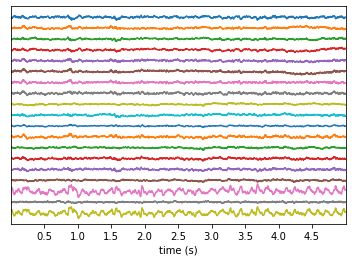

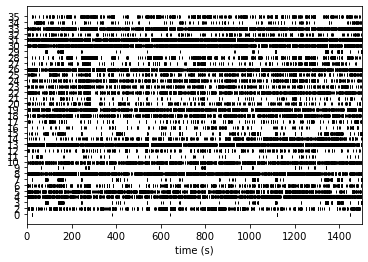

In [12]:
sw.plot_timeseries(recording);
sw.plot_rasters(klusta_out);